In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd /content/gdrive/MyDrive/BTP/Wheat

/content/gdrive/MyDrive/BTP/Wheat


# Import TensorFlow and other libraries

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import pathlib
from tqdm.notebook import tqdm
import pickle 
import shutil

import cv2
from skimage.io import imread as sk_imread, imshow as sk_imshow
from skimage.transform import resize as sk_resize

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

**NOTE**
* Opencv uses BGR format while reading images, but other libraries like matplotlib, skimage use BGR format. Also while resizing, the shape is in the form of width, height. Hence to avoid confusion, try not using opencv that much. When you do, be carefull. 
* For resizing, we have used opencv as it is faster. 
* In general, while dealing with imaging libraries, be careful about arguments, inputs and outputs. 

## Dataset Properties

In [4]:
DATA_DIR = 'dataset'

def get_file_paths(main_dir):
  file_paths = {}
  for root, dir, files in os.walk(main_dir):
    if root == main_dir:
      continue
    class_damage = os.path.basename(root)
    file_paths[class_damage] = [os.path.join(root, filename) for filename in files]
  return file_paths

file_paths = get_file_paths(DATA_DIR)
print('classes found: ', file_paths.keys())
print('sample path:', file_paths['Shrivel'][0])

classes found:  dict_keys(['Healthy', 'Shrivel', 'Black', 'Chalky', 'Green'])
sample path: dataset/Shrivel/S01198.JPG


In [5]:
print('count of images in each class')
print('*'*30)
count = 0
for damage in file_paths.keys():
  print(damage, len(file_paths[damage]))
  count += len(file_paths[damage])

print('')
print('Total images', count)

count of images in each class
******************************
Healthy 2099
Shrivel 2081
Black 2065
Chalky 2076
Green 2076

Total images 10397


In [6]:
ind = np.random.randint(0, 500)
sample_img = sk_imread(file_paths['Shrivel'][ind])
print('Shape of image:', sample_img.shape)
print('Type of image', type(sample_img))

Shape of image: (6000, 4000, 3)
Type of image <class 'numpy.ndarray'>


Sample and Resized Image

In [7]:
IMG_HEIGHT = 300
IMG_WIDTH = 200
IMG_CHANNELS = 3

* cv2.resize takes parameter as (width, height) and not (height, width)

(6000, 4000, 3)
(300, 200, 3)


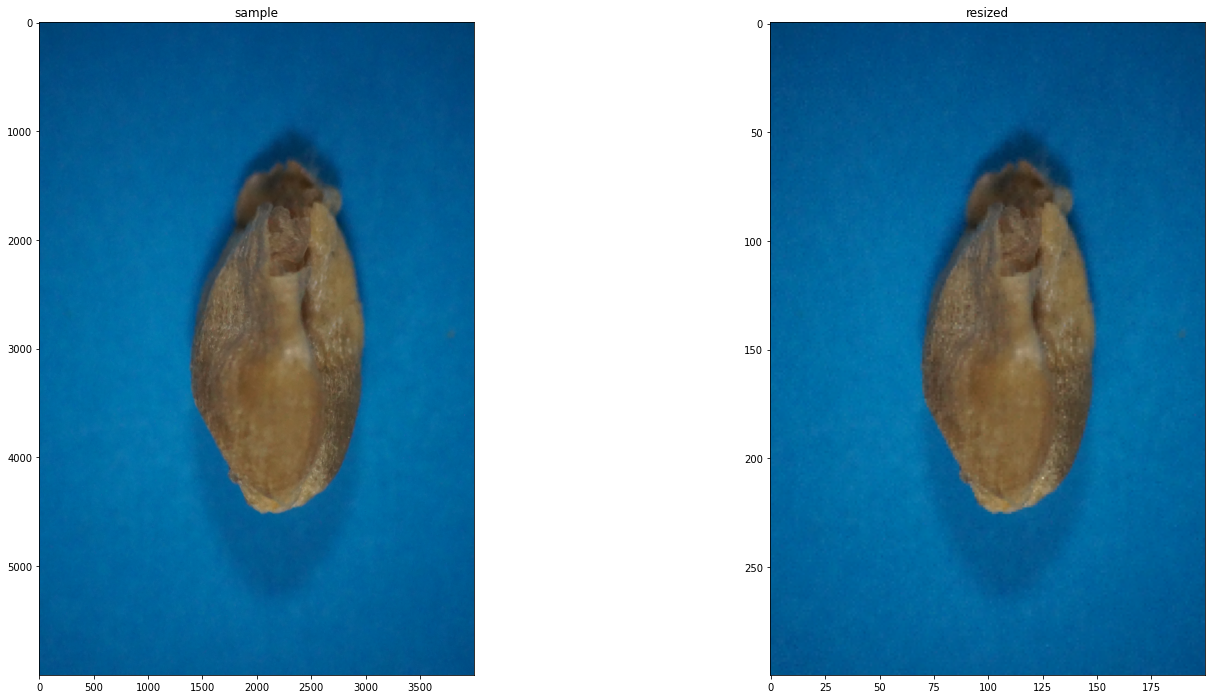

In [8]:
ind = np.random.randint(0, 100)
sample_img = sk_imread(file_paths['Shrivel'][ind])
#Opencv resizse keeps the dtype as uint8 after resizing
#Also it takes param as width, height and not height, width
resized_img = cv2.resize(sample_img, (IMG_WIDTH, IMG_HEIGHT))
print(sample_img.shape)
print(resized_img.shape)
fig, axes = plt.subplots(1, 2, figsize=(24, 12))
ax = axes.ravel()
ax[0].imshow(sample_img)
ax[0].set_title('sample')
ax[1].imshow(resized_img)
ax[1].set_title('resized')
plt.show()

# Saving dataframe and the image arrays

Creating a dataframe saving the paths and the classes. 
* Note: this dataframe we will use for the rest of the modeling. This is for easier access to array forms and back through the indices. 

In [9]:
#getting total count of img
total_imgs = 0
for dmg in file_paths:
  total_imgs += len(file_paths[dmg])
print('total number of images:', total_imgs)

#Adding path and class to the dataframe
df = pd.DataFrame()
df['path'] = np.zeros(total_imgs)
df['class'] = np.zeros(total_imgs)

index = 0
for dmg in file_paths:
  dmg_list = []
  for pth in file_paths[dmg]:
    dmg_list.append((pth,dmg))

  df.iloc[index:index+len(dmg_list)] = dmg_list
  index += len(dmg_list)

print('df shape:', df.shape)
df.head()

total number of images: 10397
df shape: (10397, 2)


,path,class
0,dataset/Healthy/H01101.JPG,Healthy
1,dataset/Healthy/H01102.JPG,Healthy
2,dataset/Healthy/H01103.JPG,Healthy
3,dataset/Healthy/H01104.JPG,Healthy
4,dataset/Healthy/H01105.JPG,Healthy


Sanity Check 

In [10]:
count = 0
for pth in df['path']:
  if os.path.exists(pth):
    count += 1

print('Checking if all paths exist')
print(count, 'should be equal to', total_imgs)

Checking if all paths exist
10397 should be equal to 10397


In [11]:
temp = df['path'].apply(lambda x:os.path.basename(os.path.dirname(x)))
np.all(temp == df['class'])

True

In [12]:
#Checking for duplicates
dup_count = 0
for damage in file_paths.keys():
  t = df[df['class']==damage]['path']
  dup_count += len(t.drop_duplicates())

print('Checking for duplicates')
print(dup_count, 'should be equal to', total_imgs)

Checking for duplicates
10397 should be equal to 10397


Saving the df for future use

In [13]:
flag = False
if flag: 
  with open('pickled_df.pkl', 'wb') as f: pickle.dump(df, f)
  print('File Saved')

Resizing and Saving the Image Arrays in X

* We are going to do our modeling on 300x200 resolution images. Hence we are first resizing and then storing all the image arrays in X
* **NOTE**: Make sure that dtype of X is 'uint8' for occupying low memory

In [14]:
flag = False                           
if flag:
  X = np.zeros((len(df), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)).astype('uint8')
  for i, pth in tqdm(enumerate(df['path']), total=len(df)):
    X[i] = cv2.resize(sk_imread(pth), (IMG_WIDTH, IMG_HEIGHT))
    if i % 1000 == 0: 
      with open ('pickled_X.pkl', 'wb') as f: pickle.dump(X, f)
      print('file saved after iteration', i)
  with open ('pickled_X.pkl', 'wb') as f: pickle.dump(X, f)
  print('Final Save Done')                       

* Hence we have our structured paths and classes in df variable. The array at index i in X represents the image at index i in df variable. 
* Hence these both will be used to keep track of image paths, class and their resized array form.

In [15]:
flag = False
if flag: 
  with open('pickled_df.pkl', 'wb') as f: pickle.dump(df, f)
  with open('pickled_X.pkl', 'wb') as f: pickle.dump(X, f)
  print('File Saved')

# Sanity Check 

In [16]:
with open('pickled_X.pkl', 'rb') as f: X = pickle.load(f)
with open('pickled_df.pkl', 'rb') as f: df = pickle.load(f)

In [17]:
print('Shape:', X.shape)
print('dtype:', X.dtype)

Shape: (10397, 300, 200, 3)
dtype: uint8


Black


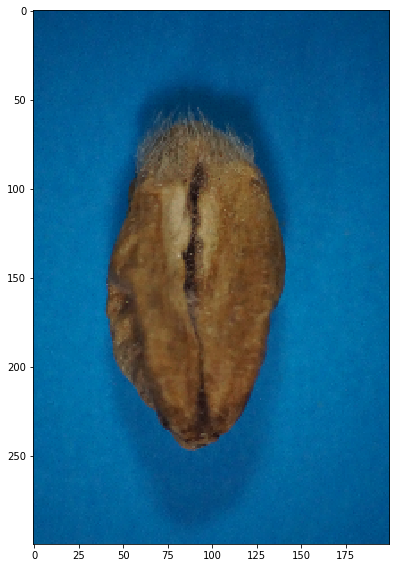


Green


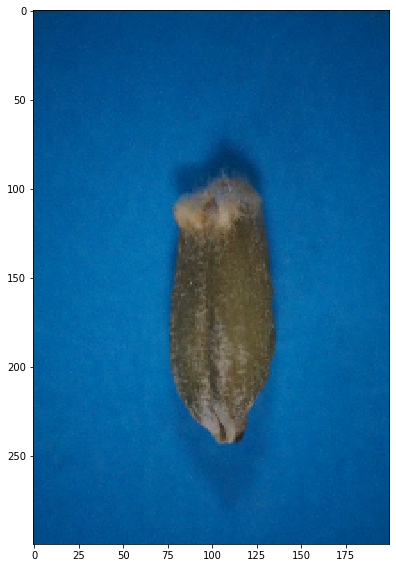


Green


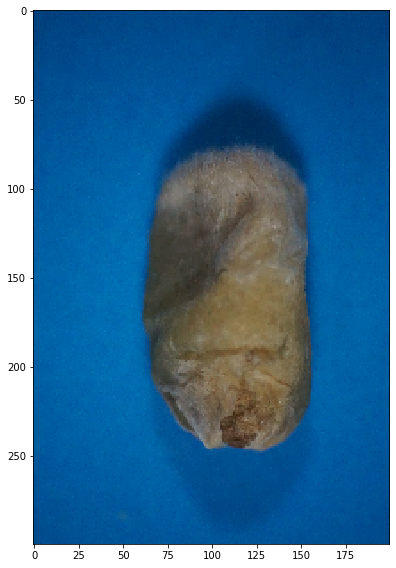


Shrivel


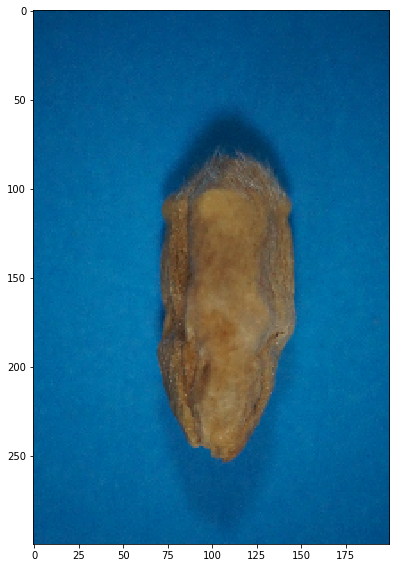


Green


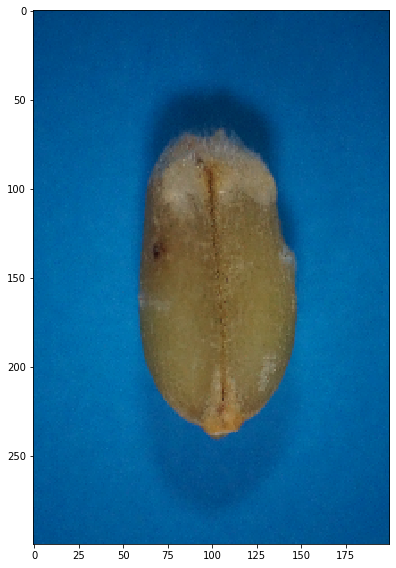


Chalky


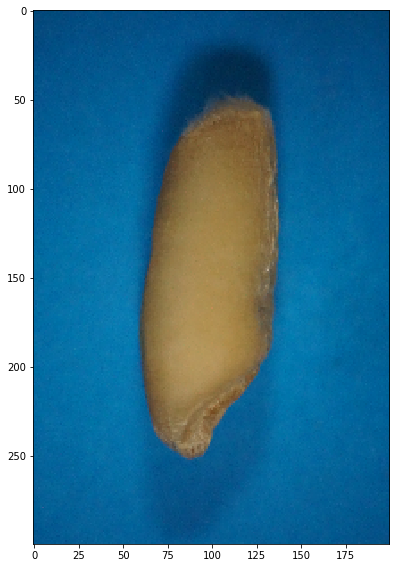


Chalky


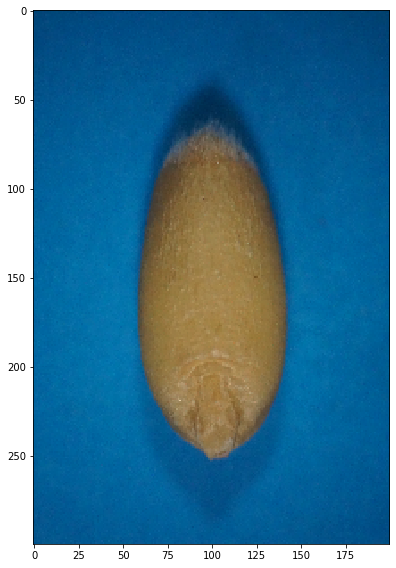


Healthy


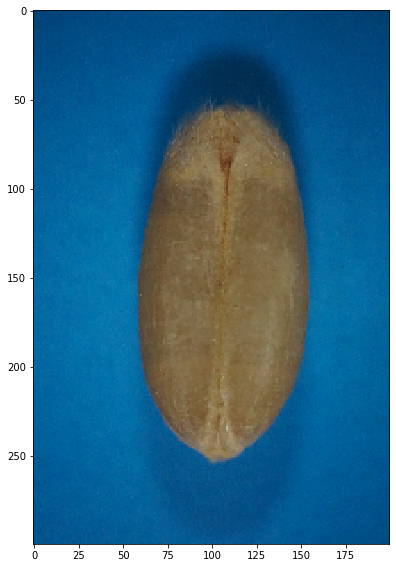


Shrivel


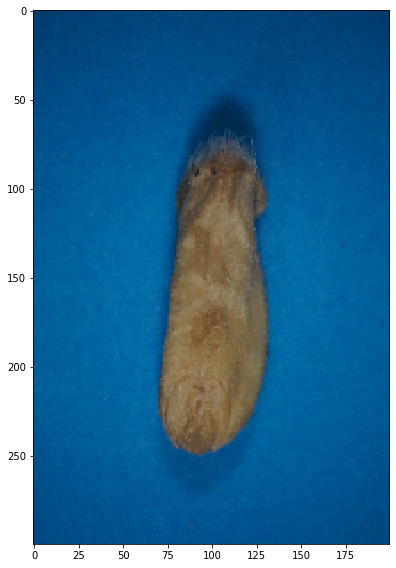


Green


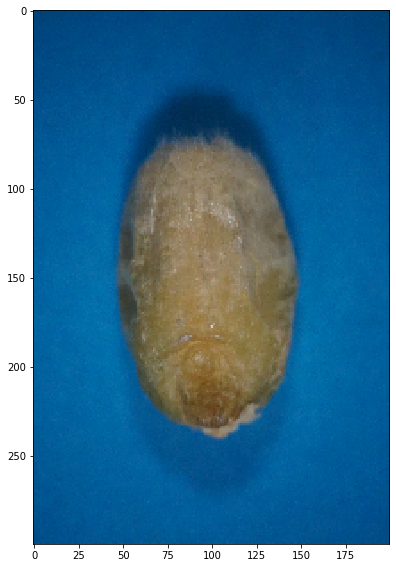

In [18]:
inds = np.random.randint(0, len(df), 10)

for ind in inds:
  plt.figure(figsize=(16, 8))
  print(df['class'].iloc[ind])
  sk_imshow(X[ind])
  plt.show()
  print('')

Looking for anomalies 

In [19]:
temp_df = df.copy()
temp_x = X.reshape((X.shape[0], X.shape[1]*X.shape[2]*X.shape[3]))
temp_df['mean_pixel'] = np.mean(temp_x, axis=1)
temp_df['max_pixel'] = np.max(temp_x, axis=1)
temp_df['min_pixel'] = np.min(temp_x, axis=1)
temp_df.head(1)

,path,class,mean_pixel,max_pixel,min_pixel
0,dataset/Healthy/H01101.JPG,Healthy,83.666539,185,0


In [20]:
temp_df.describe()

,mean_pixel,max_pixel,min_pixel
count,10397.000000,10397.000000,10397.0
mean,84.242901,190.804078,0.0
std,2.363269,10.024959,0.0
min,72.716444,173.000000,0.0
25%,82.627461,184.000000,0.0
50%,84.502006,188.000000,0.0
75%,85.947561,194.000000,0.0
max,90.887861,255.000000,0.0


* No anomalies observed 

Checking for duplicates

In [21]:
print('Both values below should be =', len(df))
print(len(np.unique(df['path'].values)))
print(len(temp_df[['mean_pixel', 'max_pixel', 'min_pixel']].drop_duplicates()))

Both values below should be = 10397
10397
10395
